In [2]:
%load_ext autoreload
%autoreload 2
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/rishisadhir/Documents/OMSC/DL


In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset

# Model and evaluation
from models.id_only_mf import MatrixFactorization
from evaluation import evaluate_ranking_model

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


## Data preprocessing

1.	Load raw data
Reads MovieLens “ratings”, “users” and “movies” files into pandas DataFrames.
2.	Clean & filter
• Drops ratings for nonexistent movies
• Keeps only ratings ≥ threshold (default 4)
• Converts Unix timestamps to datetime
3.	Build user timelines
Sorts each user’s interactions by time and collects their movie‑ID sequence.
4.	Split sequences
For each user with ≥ 3 events, chops their list into train, validation and test segments (by ratios 0.8/0.1/0.1).
5.	Construct training examples
For every prefix of length ≥ 2 in each user’s train split, emits one example comprising:
    - the prefix
    - the next (positive) item
    - K randomly sampled negatives (items the user never saw)
6.	Pad & mask
Right‐pad each prefix to a fixed length (max_len, default 50) with 0s, and build a matching binary mask.
7.	Build side‐feature tables
    - Users: bucket ages, drop ZIP, one‐hot encode gender & occupation
    - Movies: one‐hot encode genres, extract release year from title

At the end you have:
- A list of prefix / positive / negative examples, all padded for model input
- Dense user and movie feature tables for any tabular model components.

In [15]:
data_dir = "./data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

# 2) build per-user sequences & splits
user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")

# 5) pad to fixed length
max_len   = 50
train_exs = pad_sequences(train_exs, max_len=max_len)
val_exs   = pad_sequences(val_exs,   max_len=max_len)

print(f"Train examples: {len(train_exs)},  Val examples: {len(val_exs)}")

Train examples: 445746,  Val examples: 51222


## Matrix Factorization (MF)

- **Goal**  
  Approximate the user–item interaction matrix \(R\) by two low‑rank factors:  
  $$R \approx U\,V^{T}$$

- **Embeddings**  
  - $U \in \mathbb{R}^{n_{\text{users}}\times k}$: each row $u_{i}$ is a $k$‑dimensional user vector  
  - $V \in \mathbb{R}^{n_{\text{items}}\times k}$: each row $v_{j}$ is a $k$‑dimensional item vector  

- **Prediction**  
  $$\hat r_{i,j} = u_{i}\cdot v_{j}
    = \sum_{\ell=1}^{k} U_{i,\ell}\,V_{j,\ell}$$

- **Training objectives**  
  - **Pointwise (MSE)**  
    $$\min_{U,V}\;\sum_{(i,j)\in\mathcal{D}}
      \bigl(r_{i,j} - \hat r_{i,j}\bigr)^{2}
      + \lambda\bigl(\lVert u_{i}\rVert^{2} + \lVert v_{j}\rVert^{2}\bigr)$$  
  - **Pairwise (BPR)**  
    $$\min_{U,V}\;
      -\sum_{(i,p,n)} \ln\sigma\bigl(\hat r_{i,p} - \hat r_{i,n}\bigr)$$

- **Why it works**  
  1. Learns compact “taste” factors without explicit features  
  2. Compresses a large, sparse matrix into dense vectors  
  3. Enables very fast inference via a simple dot‑product  

In [17]:
batch_size = 1024

train_ds     = MFTrainDataset(train_exs, num_negatives=1)
val_ds       = MFTrainDataset(val_exs,   num_negatives=1)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

num_users = ratings["UserID"].nunique()
num_items = ratings["MovieID"].nunique()

mf        = MatrixFactorization(num_users, num_items, embedding_dim=32).to(device)
optimizer = optim.Adam(mf.parameters(), lr=1e-3)

def bpr_loss(pos_scores, neg_scores):
    return -(pos_scores - neg_scores).sigmoid().log().mean()

print("Batches per epoch:", len(train_loader))


Batches per epoch: 436


Epoch 1/15 — Train: 1.9805, Val: 2.2818
Epoch 2/15 — Train: 1.8194, Val: 2.1819
Epoch 3/15 — Train: 1.6704, Val: 2.0864
Epoch 4/15 — Train: 1.5319, Val: 1.9939
Epoch 5/15 — Train: 1.4020, Val: 1.9033
Epoch 6/15 — Train: 1.2788, Val: 1.8135
Epoch 7/15 — Train: 1.1610, Val: 1.7231
Epoch 8/15 — Train: 1.0487, Val: 1.6314
Epoch 9/15 — Train: 0.9400, Val: 1.5383
Epoch 10/15 — Train: 0.8359, Val: 1.4450
Epoch 11/15 — Train: 0.7386, Val: 1.3534
Epoch 12/15 — Train: 0.6495, Val: 1.2661
Epoch 13/15 — Train: 0.5704, Val: 1.1858
Epoch 14/15 — Train: 0.5021, Val: 1.1140
Epoch 15/15 — Train: 0.4451, Val: 1.0518


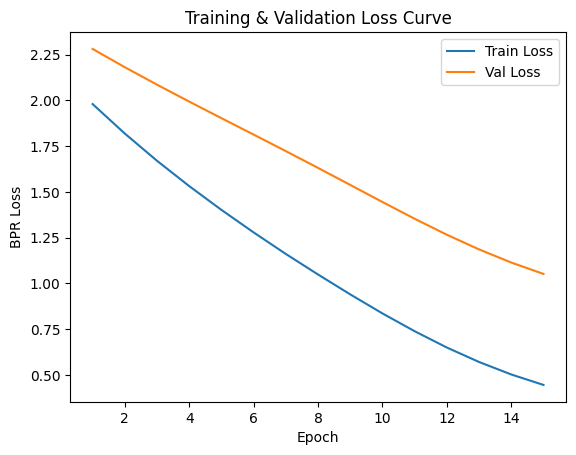

In [20]:
epochs = 15
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # ——— train ———
    mf.train()
    tot_train = 0.0
    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)
        optimizer.zero_grad()
        loss = bpr_loss(mf(user, pos), mf(user, neg))
        loss.backward()
        optimizer.step()
        tot_train += loss.item()
    avg_train = tot_train / len(train_loader)
    train_losses.append(avg_train)

    # ——— val ———
    mf.eval()
    tot_val = 0.0
    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)
            tot_val += bpr_loss(mf(user, pos), mf(user, neg)).item()
    avg_val = tot_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")

# Cell 6: plot curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

## Evaluation Procedure

### 1. Metrics definitions
- **Hit@K**  
  Returns 1 if the true (positive) item is ranked $\le K$, else 0.
- **NDCG@K**  
  Returns $\displaystyle \frac{1}{\log_{2}(\mathrm{rank}+1)}$ if $\mathrm{rank}\le K$, else 0.
- **MRR** (Mean Reciprocal Rank)  
  $\displaystyle \mathrm{MRR} = \frac{1}{\mathrm{rank}}$
- **MAP** (Mean Average Precision)  
  For a single positive item, $\mathrm{AP} = \frac{1}{\mathrm{rank}}$

### 2. Negative sampling
Given a user prefix (items in train + validation) and the global item set, sample $(\mathrm{candidate\_size} - 1)$ negatives uniformly from items the user hasn’t seen.

### 3. Per‑user evaluation loop
For each user with at least one test item:  
1. **Build prefix** = `train_seq + val_seq`  
2. **Held‑out positive** = `test_seq[0]`  
3. **Sample negatives** (size = candidate_size – 1) excluding prefix & positive  
4. **Candidates** = `[positive] + negatives`  
5. **Score all candidates** in one forward pass:  
   ```python
   users_t = torch.tensor([user] * candidate_size, dtype=torch.long, device=device)
   items_t = torch.tensor(candidates,         dtype=torch.long, device=device)
   scores  = model(users_t, items_t).cpu().numpy()

In [21]:
metrics = evaluate_ranking_model(
    model=mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.1750
- NDCG@10: 0.0797
- MRR: 0.0778
- MAP: 0.0778
